In [2]:
import pandas as pd
import numpy as np
import collections
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/validation.csv')
test  = pd.read_csv('./data/test.csv')

In [12]:
train.shape, valid.shape, test.shape

((2430981, 25), (303925, 25), (303375, 22))

In [13]:
# difference in columns between train and test data
set(train.columns) - set(train.columns).intersection(set(test.columns))

{'bidprice', 'click', 'payprice'}

In [3]:
t = train.drop(['bidprice','click','payprice'], axis=1)

In [4]:
v = valid.drop(['bidprice','click','payprice'], axis=1)

# 1.1 basic statistics

In [11]:
# numImps
numImps = train.shape[0]
numImps

2430981

In [8]:
numClicks = train['click'].sum()
numClicks

1793

In [9]:
Cost = train['payprice'].sum()
Cost

189984608

In [12]:
CTR = numClicks / numImps
CTR

0.0007375623256619447

In [14]:
avgCPM = Cost / numImps  
avgCPM

78.15141623895867

In [15]:
avgCPC = Cost / numClicks
avgCPC

105959.06748466258

In [19]:
# statistics of continuous variables
train[['click','bidprice', 'slotprice','slotwidth', 'slotheight']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
click,2430981.0,0.000738,0.027148,0.0,0.0,0.0,0.0,1.0
bidprice,2430981.0,272.962046,28.911533,227.0,241.0,294.0,300.0,300.0
slotprice,2430981.0,26.717825,37.044439,0.0,0.0,5.0,50.0,300.0
slotwidth,2430981.0,577.421826,321.673791,120.0,300.0,336.0,960.0,1000.0
slotheight,2430981.0,188.572264,131.494564,50.0,90.0,90.0,250.0,600.0


In [21]:
train.nunique()

click                   2
weekday                 7
hour                   24
bidid             2430981
userid            2342677
useragent              38
IP                 503975
region                 35
city                  370
adexchange              5
domain              23013
url                763961
urlid                   1
slotid              52283
slotwidth              21
slotheight             14
slotvisibility         11
slotformat              4
slotprice             286
creative              131
bidprice                8
payprice              301
keypage                19
advertiser              9
usertag            744036
dtype: int64

# 1.2 Further Analysis

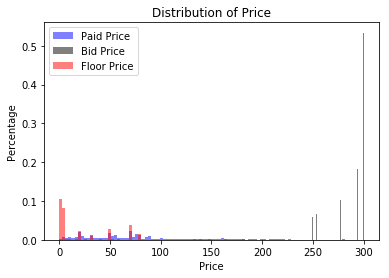

In [49]:
# Histograms of prices
n, bins, patches = plt.hist(train['payprice'],  100, normed=1, facecolor='blue', alpha=0.5, label='Paid Price')

n, bins, patches = plt.hist(train['bidprice'], 100, normed=1, facecolor='black', alpha=0.5, label='Bid Price')
n, bins, patches = plt.hist(train['slotprice'], 100, normed=1, facecolor='red', alpha=0.5, label='Floor Price')

plt.xlabel('Price')
plt.ylabel('Percentage')
plt.title('Distribution of Price')
# plt.grid(True)
plt.legend()

plt.show() # Quite a discrepancy in bid and paid prices

# 1.3 Additional findings

In [22]:
## ANALYSIS BY ADVERTISER
train_by_advertiser = pd.DataFrame({'impressions': train.groupby('advertiser').size()}).reset_index() # Total Impressions
train_by_advertiser = train_by_advertiser.join(pd.DataFrame({'clicks': train[train['click'] == 1].groupby('advertiser').size()}).reset_index(drop=True)) # Total Clicks
train_by_advertiser['CTR'] = train_by_advertiser['clicks']/train_by_advertiser['impressions']*100 # Click-Through Rate
train_by_advertiser = train_by_advertiser.join(pd.DataFrame({'cost': train.groupby(['advertiser'])['payprice'].sum()}).reset_index(drop=True)/1000) # Total Pay/Cost
train_by_advertiser['CPM'] = train_by_advertiser['cost']*1000/train_by_advertiser['impressions'] # Cost per-mille (Cost per Thousand Impressions)
train_by_advertiser['eCPC'] = train_by_advertiser['cost']/train_by_advertiser['clicks'] # Effective Cost-per-Click


## ANALYSIS BY DAY
train_by_weekday = pd.DataFrame({'impressions': train.groupby('weekday').size()}).reset_index() # Total Impressions
train_by_weekday = train_by_weekday.join(pd.DataFrame({'clicks': train[train['click'] == 1].groupby('weekday').size()}).reset_index(drop=True)) # Total Clicks
train_by_weekday['CTR'] = train_by_weekday['clicks']/train_by_weekday['impressions']*100 # Click-Through Rate
train_by_weekday = train_by_weekday.join(pd.DataFrame({'cost': train.groupby(['weekday'])['payprice'].sum()}).reset_index(drop=True)/1000) # Total Pay/Cost
train_by_weekday['CPM'] = train_by_weekday['cost']*1000/train_by_weekday['impressions'] # Cost per-mille (Cost per Thousand Impressions)
train_by_weekday['eCPC'] = train_by_weekday['cost']/train_by_weekday['clicks'] # Effective Cost-per-Click

## ANALYSIS BY HOUR
train_by_hour = pd.DataFrame({'impressions': train.groupby('hour').size()}).reset_index() # Total Impressions
train_by_hour = train_by_hour.join(pd.DataFrame({'clicks': train[train['click'] == 1].groupby('hour').size()}).reset_index(drop=True)) # Total Clicks
train_by_hour['CTR'] = train_by_hour['clicks']/train_by_hour['impressions']*100 # Click-Through Rate
train_by_hour = train_by_hour.join(pd.DataFrame({'cost': train.groupby(['hour'])['payprice'].sum()}).reset_index(drop=True)/1000) # Total Pay/Cost
train_by_hour['CPM'] = train_by_hour['cost']*1000/train_by_hour['impressions'] # Cost per-mille (Cost per Thousand Impressions)
train_by_hour['eCPC'] = train_by_hour['cost']/train_by_hour['clicks'] # Effective Cost-per-Click

## ANALYSIS OF SUCCESSFUL CLICKS
train_only_clicks = train[train['click'] == 1]
train_only_clicks.groupby('weekday').size()
train_only_clicks.groupby('hour').size()
train_only_clicks.groupby('advertiser').size()
train_only_clicks.groupby('weekday').size()

weekday
0    271
1    249
2    286
3    283
4    264
5    247
6    193
dtype: int64

In [23]:
train_by_advertiser

,advertiser,impressions,clicks,CTR,cost,CPM,eCPC
0,1458,492353,385,0.078196,33968.736,68.992646,88.230483
1,2259,133673,43,0.032168,12428.238,92.974931,289.028791
2,2261,110122,36,0.032691,9873.779,89.662184,274.271639
3,2821,211366,131,0.061978,18828.044,89.077922,143.725527
4,2997,49829,217,0.435489,3129.267,62.800116,14.420585
5,3358,264956,202,0.076239,22447.231,84.720599,111.124906
6,3386,455041,320,0.070323,34931.823,76.766320,109.161947
7,3427,402806,272,0.067526,30458.711,75.616329,111.980555
8,3476,310835,187,0.060161,23918.779,76.950083,127.907909


In [24]:
train_by_weekday

,weekday,impressions,clicks,CTR,cost,CPM,eCPC
0,0,420955,271,0.064377,32204.115,76.502512,118.834373
1,1,368164,249,0.067633,30284.921,82.259322,121.626189
2,2,296438,286,0.096479,23727.961,80.043588,82.964899
3,3,339627,283,0.083327,25993.847,76.536456,91.851049
4,4,326018,264,0.080977,25317.709,77.657396,95.900413
5,5,340642,247,0.072510,27183.974,79.802179,110.056575
6,6,339137,193,0.056909,25272.081,74.518796,130.943425


## To do list (^: already down, @: currently focused)
- ^ weekday
- ^ hour
- ^ bidid    (should be dropped)
- ^ userid (should be dropped)
- ^ useragent
- ^ IP (long-tail)
- ^ region
- ^ city
- ^ adexchange
- ^ domain (long-tail)
- ^ url (long-tail)
- ^ urlid (should be dropped)
- ^ slotid (long-tail)
- ^ slotwidth
- ^ slotheight
- ^ slotvisibility
- ^ slotformat (contains 'Na')
- ^ slotprice
- ^ creative
- ^ keypage (contains 'null')
- ^ advertiser
- ^ usertag (list of values, long-tail, contains 'null')

## ordinal (discrete) variables

In [9]:
def investigate(data, log=False, ord=False):
  feat_with_missing = data
#   feat = feat_with_missing.where(feat_with_missing != -1).dropna()
  feat = feat_with_missing

  print('number of items (include -1): {}'.format(len(feat_with_missing)))
  print('number of unique values (include -1): {}'.format(feat_with_missing.nunique()))
#   print('number of missing values: {}'.format(len(feat_with_missing) - len(feat)))
  print('min: {}'.format(min(feat)))
  print('max: {}'.format(max(feat)))
  
  # plot histogram
  fig = plt.figure()
  ax = plt.gca()
  bins = 20
  if ord:
    bins = int(max(feat) - min(feat) + 1) * 2
#     print('number of bins: {}'.format(bins))
  ax.hist(feat, bins=bins, alpha=0.8)
  if log:
    ax.set_yscale('log')
  
  
  

number of items (include -1): 3038281
number of unique values (include -1): 21
min: 120
max: 1000


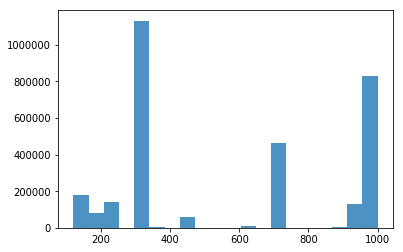

In [126]:
investigate(data['slotwidth'])

number of items (include -1): 3038281
number of unique values (include -1): 14
min: 50
max: 600


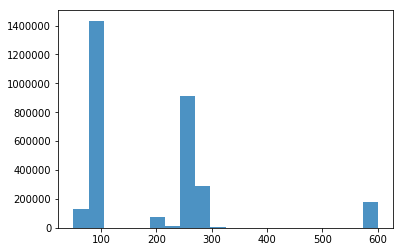

In [128]:
investigate(data['slotheight'])

In [131]:
# further preprocessing could be helpful
Counter(data['slotvisibility']).most_common()

[('0', 1257302),
 ('2', 796316),
 ('1', 331312),
 ('Na', 218864),
 ('FirstView', 177364),
 ('OtherView', 148977),
 ('SecondView', 38896),
 ('ThirdView', 23231),
 ('FourthView', 22697),
 ('255', 22058),
 ('FifthView', 1264)]

number of items (include -1): 3038281
number of unique values (include -1): 287
min: 0
max: 300


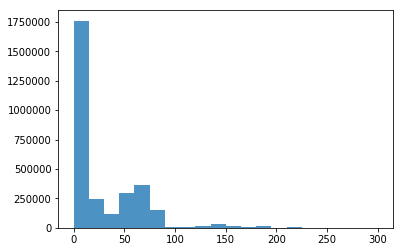

In [14]:
investigate(data['slotprice'])

(array([957499.,      0.,  61265., 710413.,  59015., 220865., 385159.,
        544223.,  68343.,  31499.]),
 array([0.        , 0.57071103, 1.14142205, 1.71213308, 2.28284411,
        2.85355513, 3.42426616, 3.99497719, 4.56568821, 5.13639924,
        5.70711026]),
 <a list of 10 Patch objects>)

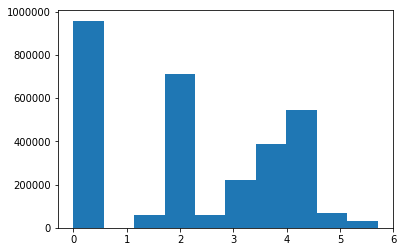

In [22]:
plt.hist(np.log(data.slotprice + 1))

## non-ordinal (discrete) variables

In [76]:
def inv_non_ord_feat(data, log_log=False, x_log=False, y_log=False):
  """
  x
  """
  feat_with_missing = data
  feat = feat_with_missing
#   feat = feat_with_missing.where(feat_with_missing != -1).dropna()

  print('number of items (include -1): {}'.format(len(feat_with_missing)))
  print('number of unique values (include -1): {}'.format(feat_with_missing.nunique()))
#   print('number of missing values: {}'.format(len(feat_with_missing) - len(feat)))
  
  count = collections.Counter(feat)
  count_distb = collections.Counter(count.values())
    
  print('most frequent 5 values:')
  for k_v in count.most_common()[:5]:
        print(k_v)
  
  fig = plt.figure()
  ax = plt.gca()
  ax.scatter(count_distb.keys(), count_distb.values(), alpha=0.4)
  plt.xlabel('number of occurence for the value')
  plt.ylabel('number of such value')
  
  if log_log:
    ax.set_xscale('log')
    ax.set_yscale('log')
  
  if x_log:
    ax.set_xscale('log')
    
  if y_log:
    ax.set_yscale('log')
    
  return count.most_common()
   

### basic non-ordinal feauture

number of items (include -1): 3038281
number of unique values (include -1): 7
min: 0
max: 6


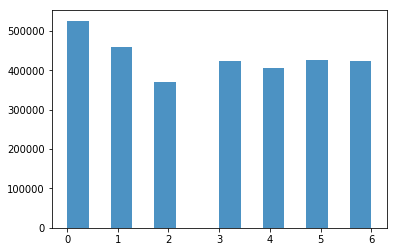

In [101]:
# plt.figure()
# plt.hist(data['weekday'], ord=True)

investigate(data['weekday'], ord=True)

number of items (include -1): 3038281
number of unique values (include -1): 24
min: 0
max: 23


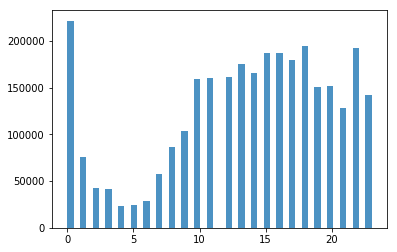

In [102]:
investigate(data['hour'], ord=True)

number of items (include -1): 3038281
number of unique values (include -1): 38
most frequent 5 values:
('windows_ie', 1826592)
('windows_chrome', 993230)
('android_safari', 76832)
('mac_safari', 46796)
('windows_firefox', 28005)


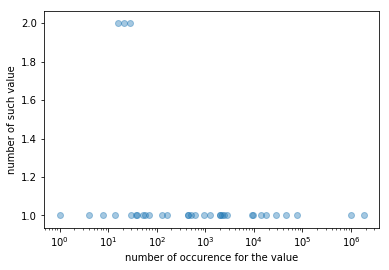

In [104]:
inv_non_ord_feat(data['useragent'], x_log=True)
# data['useragent'].head()

number of items (include -1): 3038281
number of unique values (include -1): 35
most frequent 5 values:
(216, 509590)
(80, 229889)
(146, 200336)
(94, 167398)
(276, 156933)


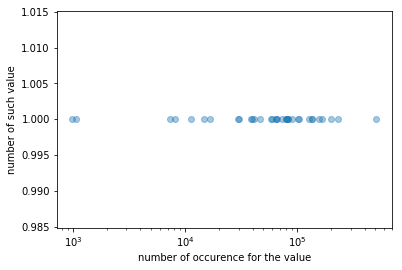

In [117]:
inv_non_ord_feat(data['region'], x_log=True)


number of items (include -1): 3038281
number of unique values (include -1): 370
most frequent 5 values:
(219, 136422)
(1, 127959)
(217, 119018)
(79, 79465)
(275, 66603)


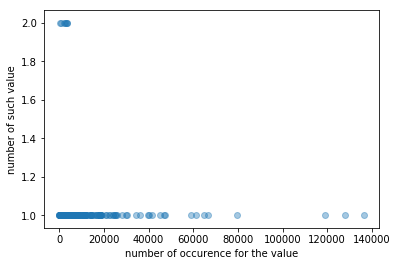

In [121]:
inv_non_ord_feat(data['city'])


number of items (include -1): 3038281
number of unique values (include -1): 131
most frequent 5 values:
('44966cc8da1ed40c95d59e863c8c75f0', 184392)
('832b91d59d0cb5731431653204a76c0e', 166599)
('86c2543527c86a893d4d4f68810a0416', 157631)
('48f2e9ba15708c0146bda5e1dd653caa', 134369)
('77819d3e0b3467fe5c7b16d68ad923a1', 133164)


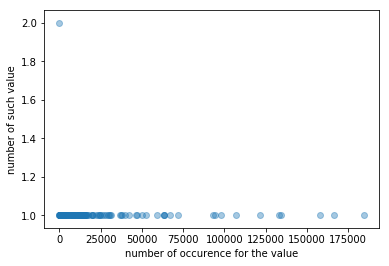

In [136]:
inv_non_ord_feat(data['creative'])

In [116]:
Counter(data['adexchange']).most_common()

[('3', 1024855), ('2', 953777), ('1', 897664), ('4', 99806), ('null', 62179)]

In [123]:
Counter(data['keypage']).most_common()

[('null', 631293),
 ('bebefa5efe83beee17a3d245e7c5085b', 615952),
 ('d29e59bf0f7f8243858b8183f14d4412', 330995),
 ('361e128affece850342293213691a043', 321183),
 ('0f951a030abdaedd733ee8d114ce2944', 285221),
 ('43f4a37f42a7c5e6219e2601b26c6976', 247036),
 ('b2e35064f3549d447edbbdfb1f707c8c', 206233),
 ('a5d0bde104fea52ea466c77b37948424', 121359),
 ('c8758e8658b05bc3a88af7b37bdf0575', 94313),
 ('f4a09c06b67d0fcce088ee6e86ca052a', 52235),
 ('9be83422522025c09a44593ecd1af8ca', 39837),
 ('15b749127478946f161a54dc0dad27c8', 20180),
 ('a3becb967c015e9acb5e72f22b100ef8', 19980),
 ('d4fc4aa65f6670f7fea6862f27084fbc', 12485),
 ('7e0e909ea89f707bc20f9585c9072081', 12050),
 ('d41d8cd98f00b204e9800998ecf8427e', 11339),
 ('aa4976c67db0f076c563a29f6697928b', 11229),
 ('a8f8eeaae5c1e2e9924328e78d9925a5', 2703),
 ('4f8e1c55abc204c2c8f1296dbc223af3', 2658)]

In [124]:
Counter(data['advertiser']).most_common()

[(1458, 615952),
 (3386, 568219),
 (3427, 502793),
 (3476, 389029),
 (3358, 330995),
 (2821, 264239),
 (2259, 167270),
 (2261, 137605),
 (2997, 62179)]

In [125]:
Counter(data['slotformat']).most_common()

[('0', 1664009), ('1', 728009), ('Na', 631293), ('5', 14970)]

### non-ordinal feauture with lots of possible values
- solution 1: set values with occurences < 50 as the same

In [84]:
# bidid_count = inv_non_ord_feat(data['bidid'])

In [85]:
# userid_count = inv_non_ord_feat(data['userid'])

number of items (include -1): 3038281
number of unique values (include -1): 528935
most frequent 5 values:
('113.106.102.*', 4290)
('118.122.85.*', 3122)
('58.254.168.*', 2836)
('210.38.1.*', 2639)
('125.39.238.*', 2456)


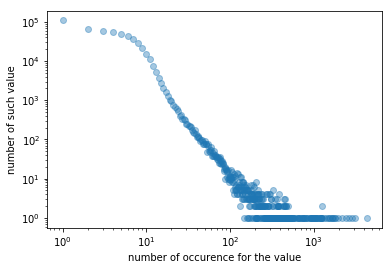

In [79]:
IP_count = inv_non_ord_feat(data['IP'], log_log=True)

number of items (include -1): 3038281
number of unique values (include -1): 25321
most frequent 5 values:
('5F1RQS9rg5scFsf', 241041)
('31xSTvprdN1RFt', 172292)
('null', 171116)
('ersbQv1RdoTy1m58uG', 101060)
('trqRTuMvjTN7X9KbuKz', 93646)


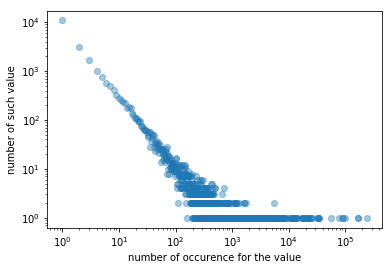

In [80]:
domain_count = inv_non_ord_feat(data['domain'], log_log=True)

number of items (include -1): 3038281
number of unique values (include -1): 914883
most frequent 5 values:
('null', 108365)
('bfa000ed663f4997db218d6da6b1510f', 26576)
('b9b27f86cd5409b505b66e27470765af', 25812)
('dedc488b98ca20707bc9a723957e7d1f', 21526)
('8dd142fa4bc566aa470b4c63e3da3d68', 18199)


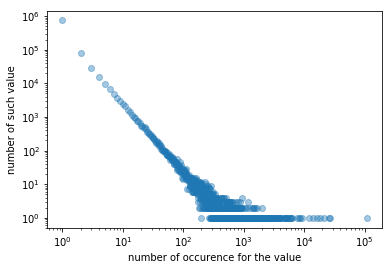

In [81]:
url_count = inv_non_ord_feat(data['url'], log_log=True)

number of items (include -1): 3038281
number of unique values (include -1): 60098
most frequent 5 values:
('ALLINONE_F_Width1', 275579)
('News_F_Width1', 118222)
('mm_10024662_3445902_11178345', 83399)
('ALLINONE_F_Width2', 75409)
('1', 53693)


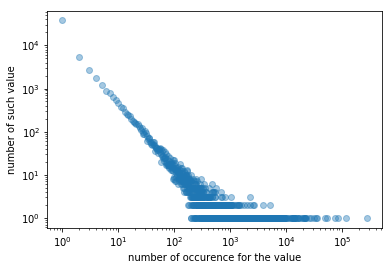

In [82]:
inv_non_ord_feat(data['slotid'], log_log=True)

number of items (include -1): 3038281
number of unique values (include -1): 903635
most frequent 5 values:
('null', 621679)
('10063', 112482)
('10006,10110', 65233)
('10006', 46984)
('13866', 33394)


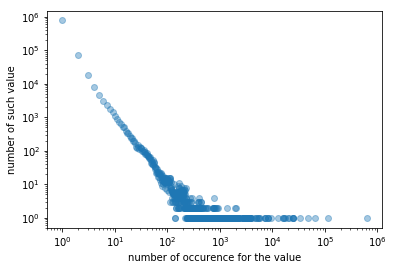

In [83]:
inv_non_ord_feat(data['usertag'], log_log=True)

In [7]:
data['usertag'].iloc[:10]

0                                               null
1                                               null
2                            10052,10006,13866,10110
3                                  13866,10063,10111
4                                               null
5                      10006,10077,10063,10057,10110
6    10083,10024,10063,13496,10093,10006,10057,10110
7                10063,10024,13800,13866,10006,10111
8                            10063,10006,10083,10110
9    13403,10031,10063,10083,10006,10077,10075,10110
Name: usertag, dtype: object

### non-ordinal feauture with limited possible values